In [1]:
#Importamos las librerías que precisaremos en este análisis.
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, calinski_harabasz_score, r2_score, roc_auc_score, recall_score, precision_score, accuracy_score, classification_report, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_union, make_pipeline
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# 0- Preprocesamiento

In [2]:
#Leemos los datos de la encuesta en forma de DataFrame.

data = pd.read_csv(r"C:\Users\joaqu\Documents\Kódigo\TP Diseño\English forms.csv")
data.head(3)

,Date,1- Watches Martin Cirio's content...,2- Where? (+),3- How often do they share?,3- How often do they comment?,3- How often do they like?,3- How often do they message him?,4- Do they speak with his words?,5- Have you ever paid him?,6- Any gifts?,...,14- Why does he post every day?,15- Does Martin Cirio deserves the money he made so far?,16- Do they consider a Martin Cirio's fan?,17- Do their friends and family know they are Martin Cirio's fans?,18- Do they engage with other fans online?,19- Where do they live?,20- Age:,21- Gender:,22- Sexual orientation:,23- Email
0,2/12/2020 11:28:21,2 o 3 veces por semana,"Instagram, YouTube",Nunca,Nunca,Pocas veces,Nunca,"Si, muchas veces",No,No,...,Porque de esa forma gana más dinero,Sí,"En el pasado sí, ahora ya no",No me considero un faraminion,Nunca,Gran Buenos Aires (conurbano),Entre 19 y 25 años,Femenino,Heterosexual,NaN
1,2/12/2020 11:44:46,Dejé de consumirlo,NaN,Nunca,Nunca,Nunca,Nunca,"No, nunca",No,No,...,No lo sé/No me importa,No,No,No me considero un faraminion,Nunca,Ciudad Autónoma de Buenos Aires,Entre 19 y 25 años,Femenino,Heterosexual,NaN
2,6/12/2020 22:35:06,Más de 1 vez por día,"Instagram, YouTube",A veces,A veces,Muchas veces,A veces,"Si, muchas veces","Sí, fui a ver uno de sus shows",No,...,Porque así los algoritmos favorecen a su perfi...,Sí,Sí,Si,Nunca,Ciudad Autónoma de Buenos Aires,Entre 26 y 30 años,Femenino,Heterosexual,lauri-jg@hotmail.com


In [3]:
#Vemos de qué tipo es la información y si hay valores faltantes.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 27 columns):
 #   Column                                                                     Non-Null Count  Dtype 
---  ------                                                                     --------------  ----- 
 0   Date                                                                       391 non-null    object
 1   1- Watches Martin Cirio's content...                                       390 non-null    object
 2   2- Where? (+)                                                              381 non-null    object
 3   3- How often do they share?                                                391 non-null    object
 4   3- How often do they comment?                                              391 non-null    object
 5   3- How often do they like?                                                 391 non-null    object
 6   3- How often do they message him?                                 

In [4]:
#No necesitaremos el email en esta instancia, podemos prescindir de esa columna.

data.drop(columns = ["23- Email"], inplace = True)

In [5]:
#Alteramos la columna "Date" para que esté en formato "fecha" y no sea leida como un texto más.

data["Date"] = pd.to_datetime(data["Date"], dayfirst=True)

In [6]:
#Imputamos el pequeño número de nulos en 2 de las columnas:

data["1- Watches Martin Cirio's content..."].fillna(method="ffill", inplace=True)
data["2- Where? (+)"].fillna(method="ffill", inplace=True)

In [7]:
# Ahora comienza el período de encoding. Para aquellos sin formación matemática o computacional, esto podría empezar a asustarlos. 
# ¡No se preocupen! En estas anotaciones en azul iremos explicándoles paso a paso el proceso para aquellos que sean nuevos con Python o con la matemática.
# Creemos que nada mejor que la revisión entre pares para refinar el método científico, y que a la brecha tecnológica se la supera con tiempo y paciencia.

#Primero: La mayoría de los algoritmos trabaja con información numérica, por eso vamos a factorizar cada respuesta en un número.

data["1- Watches Martin Cirio's content..."].unique() #Para eso, seleccionamos todos los tipos de respuestas posibles

array(['2 o 3 veces por semana', 'Dejé de consumirlo',
       'Más de 1 vez por día', '1 vez por día', '1 vez por semana',
       'Esporádicamente, pero poco'], dtype=object)

In [8]:
#Luego: les aplicamos una función de factorización.

data_test = pd.DataFrame()
data_test["Factorized 1"] = pd.factorize(data["1- Watches Martin Cirio's content..."])[0]
data_test["Factorized 1"].value_counts(normalize=True)

2    0.465473
3    0.227621
0    0.097187
1    0.092072
5    0.086957
4    0.030691
Name: Factorized 1, dtype: float64

In [9]:
# Por último: chequeamos la compatibilidad de la respuesta numérica con la categórica.

data["1- Watches Martin Cirio's content..."].head(10) #Si dudan, pueden chequear si cada respuesta no tiene su contraparte numérica en la celda superior.

0    2 o 3 veces por semana
1        Dejé de consumirlo
2      Más de 1 vez por día
3      Más de 1 vez por día
4      Más de 1 vez por día
5      Más de 1 vez por día
6      Más de 1 vez por día
7      Más de 1 vez por día
8      Más de 1 vez por día
9    2 o 3 veces por semana
Name: 1- Watches Martin Cirio's content..., dtype: object

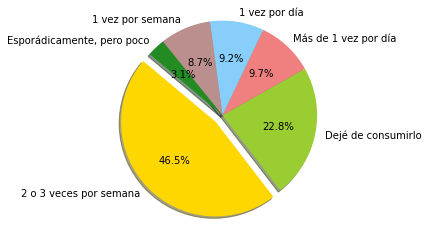

In [10]:
#Grafiquemos las frecuencias relativas en las respuestas, a ver si coinciden antes y despues de factorizar.

labels_cat = '2 o 3 veces por semana', 'Dejé de consumirlo', 'Más de 1 vez por día', '1 vez por día', '1 vez por semana','Esporádicamente, pero poco'
sizes_cat = [215, 130, 245, 210, 245, 210]
colors_cat = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'rosybrown', 'forestgreen']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice

plt.pie(data["1- Watches Martin Cirio's content..."].value_counts(normalize=True), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

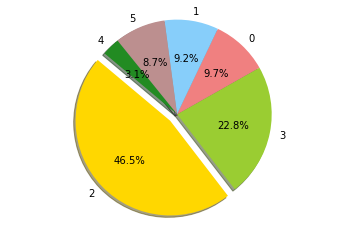

In [11]:
#Ahora la versión factorizada, vemos que ambos gráficos coinciden.

labels_cat = '2', '3', '0', '1', '5','4'
sizes_cat = [215, 130, 245, 210, 245, 210]
colors_cat = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'rosybrown', 'forestgreen']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice

plt.pie(data_test["Factorized 1"].value_counts(normalize=True), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()



In [12]:
# Al corroborar que ambas son equivalentes, podemos crear un nuevo DataFrame con cada columna factorizada. Llamaremos "data_num" al DataFrame numérico.

data_num = pd.DataFrame() 

data_num["Date"] = data["Date"]
data_num["Watches Martin Cirio's content..."] = pd.factorize(data["1- Watches Martin Cirio's content..."])[0]
data_num["Where?"] = pd.factorize(data["2- Where? (+)"])[0]
data_num["How often do they share?"] = pd.factorize(data["3- How often do they share?"])[0]
data_num["How often do they comment?"] = pd.factorize(data["3- How often do they comment?"])[0]
data_num["How often do they like?"] = pd.factorize(data["3- How often do they like?"])[0]
data_num["How often do they message?"] = pd.factorize(data["3- How often do they message him?"])[0]
data_num["Do they speak with his words?"] = pd.factorize(data['4- Do they speak with his words?'])[0]
data_num["Have you ever paid him?"] = pd.factorize(data['5- Have you ever paid him?'])[0]
data_num["Gifts?"] = pd.factorize(data['6- Any gifts?'])[0]
data_num["Took part in activities?"] = pd.factorize(data['7- Took part in one of his activities? (+)'])[0]
data_num['If they participated in attacks, why?'] = pd.factorize(data['8- If they participated in "attacks", why?'])[0]
data_num["Feelings when attacks happen?"] = pd.factorize(data['9- How do they feel when "attacks" take place?'])[0]
data_num["Feelings when attacks have consequences?"] = pd.factorize(data['10- When those attacks have consequences on the target, how do they feel?'])[0]
data_num["Feelings about Martin Cirio's attention on his fans"] = pd.factorize(data['11- Do they feel like Martin Cirio cares for their fans?'])[0]
data_num["How often do they like?"] = pd.factorize(data['12- How do they feel when Martin Cirio is successful?'])[0]
data_num["Whishes to be an influencer?"] = pd.factorize(data['13- Whishes to be an influencer?'])[0]
data_num["Why does he post every day?"] = pd.factorize(data['14- Why does he post every day?'])[0]
data_num["Does he deserve the money made so far?"] = pd.factorize(data['15- Does Martin Cirio deserves the money he made so far?'])[0]
data_num["Consider themselves fans?"] = pd.factorize(data["16- Do they consider a Martin Cirio's fan?"])[0]
data_num["Do their close ones know they are fans?"] = pd.factorize(data["17- Do their friends and family know they are Martin Cirio's fans?"])[0]
data_num['Do they engage with other fans online?'] = pd.factorize(data['18- Do they engage with other fans online?'])[0]
data_num["Where do they live?"] = pd.factorize(data['19- Where do they live?'])[0]
data_num["Age"] = pd.factorize(data['20- Age:'])[0]
data_num["Gender"] = pd.factorize(data['21- Gender:'])[0]
data_num["Sexual orientation"] = pd.factorize(data['22- Sexual orientation:'])[0]


In [13]:
#El código "int" viene de "integer" y significa "numeros enteros". 
#Podemos ver que luego de la transformación todas las columnas se volvieron numéricas, salvo la primera que ya habíamos convertido a formato "fecha".

data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 25 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Date                                                 391 non-null    datetime64[ns]
 1   Watches Martin Cirio's content...                    391 non-null    int64         
 2   Where?                                               391 non-null    int64         
 3   How often do they share?                             391 non-null    int64         
 4   How often do they comment?                           391 non-null    int64         
 5   How often do they like?                              391 non-null    int64         
 6   How often do they message?                           391 non-null    int64         
 7   Do they speak with his words?                        391 non-null    int64         
 8   

# 1- Análisis exploratorio

In [14]:
#1- ¿Qué porcentaje de la muestra lo consume diariamente?

data["1- Watches Martin Cirio's content..."].value_counts(normalize=True) #Casi el 70% de la muestra

Más de 1 vez por día          0.465473
1 vez por día                 0.227621
2 o 3 veces por semana        0.097187
Dejé de consumirlo            0.092072
Esporádicamente, pero poco    0.086957
1 vez por semana              0.030691
Name: 1- Watches Martin Cirio's content..., dtype: float64

In [15]:
#2- Instagram y YouTube son las plataformas foco, con un 30% de dispersión dentro del que cabe añadir a Spotify. De aquí en adelante, reduciremos la dispersión.

data["2- Where? (+)"].value_counts(normalize=True) 

Instagram, YouTube                                        0.537084
Instagram                                                 0.171355
Instagram, YouTube, Spotify                               0.079284
Instagram, YouTube, Twitter                               0.040921
YouTube                                                   0.033248
Instagram, YouTube, Spotify, Twitter                      0.023018
Instagram, YouTube, Spotify, Twitter, TikTok, Facebook    0.012788
Instagram, YouTube, Spotify, Twitter, TikTok              0.012788
Instagram, YouTube, Twitter, TikTok                       0.012788
Instagram, Twitter                                        0.010230
Instagram, YouTube, Facebook                              0.010230
Facebook                                                  0.007673
Twitter                                                   0.005115
Instagram, YouTube, TikTok                                0.005115
Instagram, YouTube, Spotify, TikTok, Facebook             0.00

In [16]:
#3- Más del 30% de los encuestados comparte recurrentemente contenidos de Martin Cirio.

data["3- How often do they share?"].value_counts(normalize=True)

Nunca           0.447570
Pocas veces     0.227621
A veces         0.217391
Muchas veces    0.107417
Name: 3- How often do they share?, dtype: float64

In [17]:
#3- Un número apenas superior comenta.

data["3- How often do they comment?"].value_counts(normalize=True)

Nunca           0.345269
A veces         0.271100
Pocas veces     0.255754
Muchas veces    0.127877
Name: 3- How often do they comment?, dtype: float64

In [18]:
#3- El like parece más fácil de conseguir, un 72% de la muestra se lo da bastante seguido.

data['3- How often do they like?'].value_counts(normalize=True)

Muchas veces    0.516624
A veces         0.204604
Nunca           0.181586
Pocas veces     0.097187
Name: 3- How often do they like?, dtype: float64

In [19]:
#3- Nos sorprendió ver que un 41% de la muestra se comunica con él habitualmente.

data['3- How often do they message him?'].value_counts(normalize=True)

Nunca           0.314578
A veces         0.281330
Pocas veces     0.276215
Muchas veces    0.127877
Name: 3- How often do they message him?, dtype: float64

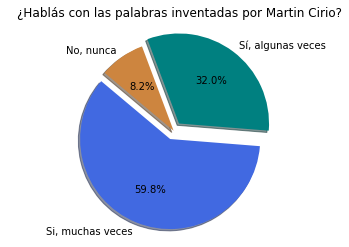

In [20]:
#4- La gran mayoría de los encuestados utiliza cotidianamente léxico inventado por Martin Cirio. Por ejemplo: "¡ZALALA!", "...o si,...o no" o "Lanos Alert".

labels_cat = 'Si, muchas veces', 'Sí, algunas veces', 'No, nunca'
colors_cat = ['royalblue','teal','peru']
explode = (0.1, 0.1, 0)

plt.pie(data['4- Do they speak with his words?'].value_counts(normalize=True), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("¿Hablás con las palabras inventadas por Martin Cirio?", loc="right")
plt.show()

In [21]:
#5- Cerca del 35% pagó por ver a Martin Cirio, empezamos a ver un 30%/35% de fans muy enérgicos.

data['5- Have you ever paid him?'].value_counts(normalize=True).nlargest(7)

No                                                                                               0.593350
Sí, fui a ver uno de sus shows                                                                   0.248082
Sí, fui a ver uno de sus shows, Si, fui a una fiesta en la que él estaba                         0.028133
Sí, fui a ver uno de sus shows, Sí, compré su libro                                              0.028133
Sí, fui a ver uno de sus shows, Si, fui a una fiesta en la que él estaba, Sí, compré su libro    0.025575
Sí, compré su libro                                                                              0.020460
No sabe/No contesta                                                                              0.015345
Name: 5- Have you ever paid him?, dtype: float64

In [22]:
#6- La virtualidad parece seguir siendo un obstáculo para los tributos no monetarios.

data['6- Any gifts?'].value_counts(normalize=True)

No    0.902813
Sí    0.097187
Name: 6- Any gifts?, dtype: float64

In [23]:
#7- Inicialmente podemos afirmar que poco menos del 70% participó en sus actividades.
#Esta respuesta, como otras que le seguirán, tiene una dispersión muy alta. En la encuesta, dejamos opciones abiertas y múltiples para captar la heterogeneidad de 
#la población de estudio. En esta etapa exploratoria haremos recortes. De aquí en adelante esos recortes estarán señalados con una letra "R" al comienzo de la celda.

data['7- Took part in one of his activities? (+)'].value_counts(normalize=True).nlargest(6)

No                                                                                                              0.317136
Sí, le hice preguntas                                                                                           0.202046
Sí, le hice preguntas, Sí, participé de los "ataques" de Faraminions                                            0.158568
Sí, le hice preguntas, Sí, participé de los "ataques" de Faraminions, Sí, ayudé a instalar un Trending Topic    0.097187
Sí, participé de los "ataques" de Faraminions                                                                   0.081841
Sí, le hice preguntas, Sí, ayudé a instalar un Trending Topic                                                   0.035806
Name: 7- Took part in one of his activities? (+), dtype: float64

No participé en ninguno                    0.488491
Por repudio a la persona que atacábamos    0.273657
Para apoyar a Martin Cirio                 0.097187
Para que el ataque tuviera más fuerza      0.058824
No sabe/No contesta                        0.046036
Porque tenía tiempo libre                  0.010230
Name: 8- If they participated in "attacks", why?, dtype: float64

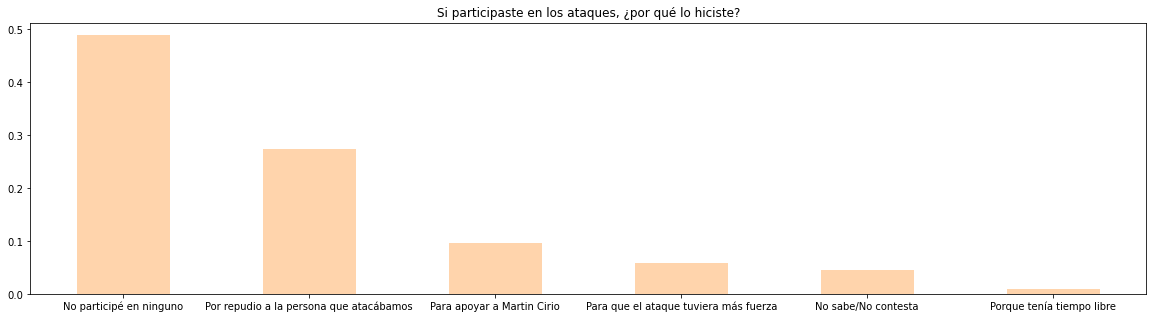

In [24]:
# R
#8- Aún con la dispersión, esta respuesta revela datos más interesantes. El 45% de los fans participan en los ataques, un número superior al que suponíamos.

data['8- If they participated in "attacks", why?'].value_counts(normalize=True, ascending=False).nlargest(6).plot(kind="bar",
                                                                                                 title = "Si participaste en los ataques, ¿por qué lo hiciste?", 
                                                                                                 figsize=(20,5), colormap = "icefire_r", rot= 0)

data['8- If they participated in "attacks", why?'].value_counts(normalize=True, ascending=False).nlargest(6)

In [25]:
# R
#9- Tanto en esta como en la siguiente respuesta vemos que, por lo menos a nivel consciente, el componente emocional no es central en los ataques.

data['9- How do they feel when "attacks" take place?'].value_counts(normalize=True).nlargest(8)

No me genera ningún sentimiento          0.447570
Orgullo                                  0.097187
Alegría                                  0.076726
Excitación                               0.074169
Orgullo, Alegría                         0.043478
Enojo                                    0.040921
No sé qué es un ataque de faraminions    0.040921
Tristeza                                 0.030691
Name: 9- How do they feel when "attacks" take place?, dtype: float64

In [26]:
# R
#10- De nuevo, el compromiso emocional está demasiado disperso como para extraer conclusiones firmes.

data['10- When those attacks have consequences on the target, how do they feel?'].value_counts(normalize=True).nlargest(8)

No me genera ningún sentimiento          0.414322
Alegría                                  0.145780
Orgullo                                  0.143223
Orgullo, Alegría                         0.069054
Enojo                                    0.051151
No sé qué es un ataque de faraminions    0.046036
Tristeza                                 0.038363
Excitación                               0.023018
Name: 10- When those attacks have consequences on the target, how do they feel?, dtype: float64

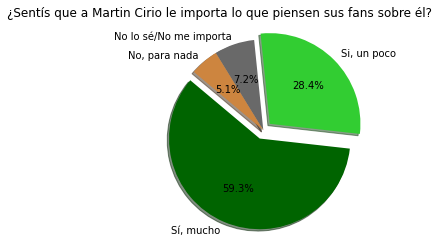

In [27]:
# R
#11- No esperábamos encontrar un 87% de acuerdo en la idea que Martin Cirio reconoce a sus fans y les importa su opinión. 
#Incluso muchos de quienes no se consideran fans parecen haber optado por un voto positivo.

labels_cat = 'Sí, mucho', 'Si, un poco', 'No lo sé/No me importa', 'No, para nada'
colors_cat = ['darkgreen','limegreen', 'dimgrey','peru']
explode = (0.1, 0.1, 0, 0)

plt.pie(data['11- Do they feel like Martin Cirio cares for their fans?'].value_counts(normalize=True), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("¿Sentís que a Martin Cirio le importa lo que piensen sus fans sobre él?", loc="right")
plt.show()

In [28]:
#R
#12- En cuanto al reconocimiento de los fans para con Martin Cirio, vemos una mezcla de sentimientos positivos e indiferencia. 
#Opciones negativas como "enojo" o "celos" solo fueron seleccionadas de manera muy marginal o descartadas.

data['12- How do they feel when Martin Cirio is successful?'].value_counts(normalize=True).nlargest(8)

Alegría                                     0.393862
No me genera ningún sentimiento             0.248082
Orgullo, Alegría                            0.150895
Orgullo                                     0.125320
Orgullo, Excitación, Alegría                0.046036
Excitación                                  0.007673
Alegría, No me genera ningún sentimiento    0.007673
Enojo, Tristeza                             0.005115
Name: 12- How do they feel when Martin Cirio is successful?, dtype: float64

In [29]:
#13- Parece que, en este caso, la mayoría de los consumidores prefiere ver a ser.

data['13- Whishes to be an influencer?'].value_counts(normalize=True)

No                                  0.659847
Sí, pero no sé cómo                 0.140665
Si, pero soy tímido/vergonzoso      0.120205
Si, y la tengo/tendré               0.043478
Si, pero algo externo me detiene    0.035806
Name: 13- Whishes to be an influencer?, dtype: float64

Porque él desea publicar contenido todos los días                 0.442455
Porque de esa forma gana más dinero                               0.242967
Porque así los algoritmos favorecen a su perfil o "lo obligan"    0.148338
No lo sé/No me importa                                            0.122762
Name: 14- Why does he post every day?, dtype: float64

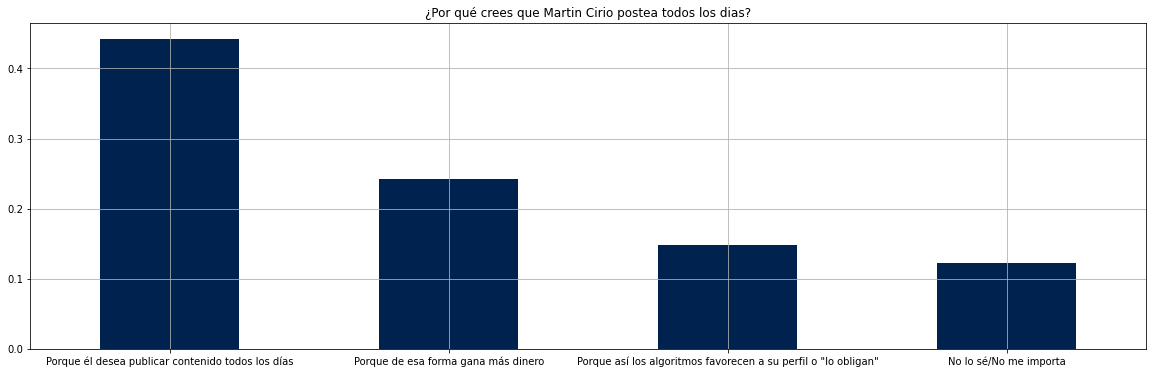

In [30]:
#R
#14- Inicialmente esperábamos ver más consumidores que reconozcan las demandas de los algoritmos. 
# 4 de cada 10 encuestados percibe algún tipo de necesidad u obligación de las plataformas como razón de las publicaciones diarias.

data['14- Why does he post every day?'].value_counts(normalize=True).nlargest(4).plot(kind="bar", grid = True,
                                                                                      title = "¿Por qué crees que Martin Cirio postea todos los dias?",
                                                                                      figsize=(20,6), colormap = "cividis", rot= 0)

data['14- Why does he post every day?'].value_counts(normalize=True).nlargest(4)

In [31]:
#15- En la actualidad, los salarios de los influencers más populares se presuponen altos. Aún así, la mayoría piensa que Martin merece los ingresos que recibe.

data['15- Does Martin Cirio deserves the money he made so far?'].value_counts(normalize=True)

Sí                              0.874680
En el pasado sí, ahora ya no    0.069054
No                              0.056266
Name: 15- Does Martin Cirio deserves the money he made so far?, dtype: float64

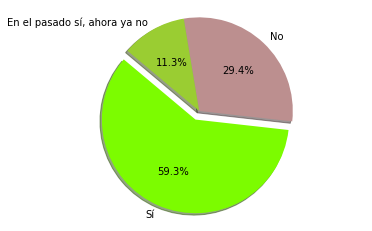

In [32]:
#16- ¿Qué porcentaje de la muestra se reconoce como fan?

data["16- Do they consider a Martin Cirio's fan?"].value_counts(normalize=True)

labels_cat = 'Sí', 'No', 'En el pasado sí, ahora ya no'
colors_cat = ['lawngreen', 'rosybrown', 'yellowgreen']
explode = (0.1, 0, 0)  # explode 1st slice

plt.pie(data["16- Do they consider a Martin Cirio's fan?"].value_counts(normalize=True), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [33]:
#17- Si casi 6 de cada 10 se consideran "faraminions", solo un 66% de esos fans lo admite frente a sus seres queridos.

data["17- Do their friends and family know they are Martin Cirio's fans?"].value_counts(normalize=True)

No me considero un faraminion    0.416880
Si                               0.386189
No lo sé                         0.117647
No                               0.079284
Name: 17- Do their friends and family know they are Martin Cirio's fans?, dtype: float64

In [34]:
#18- El engagement intra-red no parece tan intenso en esta comunidad.

data["18- Do they engage with other fans online?"].value_counts(normalize=True)

Nunca           0.578005
Alguna vez      0.237852
Usualmente      0.135550
Una sola vez    0.048593
Name: 18- Do they engage with other fans online?, dtype: float64

### Sociodemográficos

<AxesSubplot:title={'center':'Lugar de residencia'}>

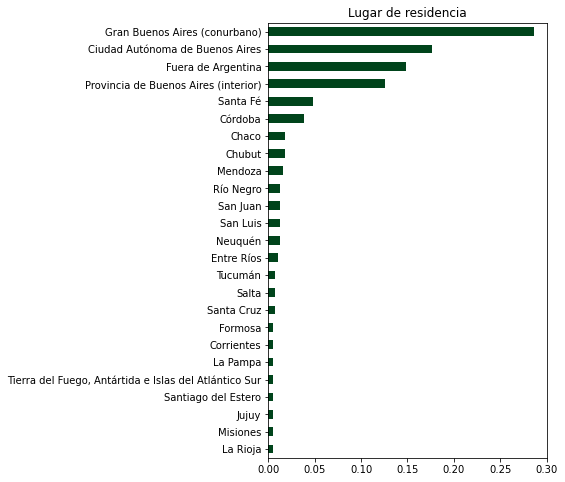

In [35]:
#19-Lugar de residencia:

data["19- Where do they live?"].value_counts(normalize=True,ascending=True).plot(kind="barh", title = "Lugar de residencia", figsize=(5,8), colormap = "Greens_r")

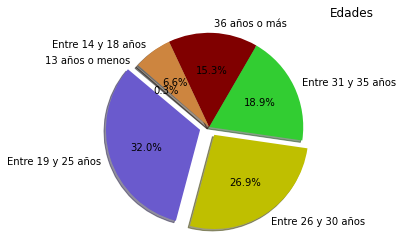

In [36]:
#20- Edad:

labels_cat = 'Entre 19 y 25 años', 'Entre 26 y 30 años', 'Entre 31 y 35 años', '36 años o más', 'Entre 14 y 18 años','13 años o menos'
colors_cat = ['slateblue', 'y', 'limegreen', 'maroon', 'peru', 'dimgrey']
explode = (0.1, 0.1, 0, 0, 0, 0)

plt.pie(data["20- Age:"].value_counts(normalize=True), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Edades", loc="right")
plt.show()

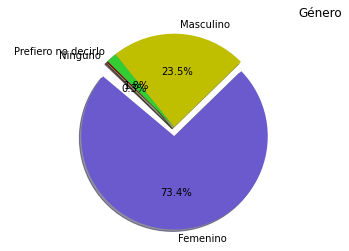

In [37]:
#21- Género:

labels_cat = 'Femenino ', 'Masculino', 'Prefiero no decirlo', 'Ninguno'
colors_cat = ['slateblue', 'y', 'limegreen', 'maroon', 'peru', 'dimgrey']
explode = (0.1, 0, 0, 0)

plt.pie(data["21- Gender:"].value_counts(normalize=True).nlargest(4), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis("equal")
plt.title("Género", loc="right")
plt.show()


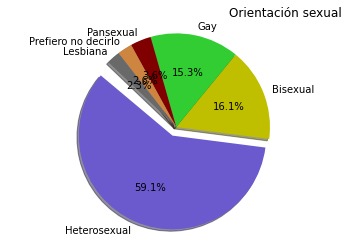

In [38]:
#22-Orientación sexual*:
#* Decidimos incluir esta pregunta luego de que durante el trabajo de campo con ciertos miembros de la comunidad LGBT+ fuimos advertidos de que,
# a pesar de estar a cargo de un enunciador gay, la cuenta de Martin Cirio era un consumo predominantemente de mujeres jóvenes y heterosexuales.
# Con los resultados, poodemos afirmar que ese presupuesto era mayormente correcto.

labels_cat = 'Heterosexual', 'Bisexual', 'Gay', 'Pansexual', 'Prefiero no decirlo','Lesbiana'
colors_cat = ['slateblue', 'y', 'limegreen', 'maroon', 'peru', 'dimgrey']
explode = (0.1, 0, 0, 0, 0, 0)

plt.pie(data["22- Sexual orientation:"].value_counts(normalize=True).nlargest(6), explode=explode, labels=labels_cat, colors=colors_cat,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Orientación sexual", loc="right")
plt.show()


# 2- Análisis heurístico

In [39]:
# Una de nuestras hipótesis es que aquellas personas que se reconocen y comportan como fans, tienen una mayor tendencia a seguir propuestas agresivas de un líder.
# A priori, creemos que las preguntas 7, 8, 10, 11, 18 y 19 pueden resultar informativas acerca de la intensidad de la relación fan-enunciador. Pero ya que podemos
# corroborarlo matemáticamente, no confiemos en nuestra creencia inicial. 

#Desde esa celda en adelante, 0 significa "no" y 1 significa "sí".

# Primero vamos a crear una nueva columna que indique si la persona participó o no en los ataques. 
# Además eliminaremos las variables repetidas para evitar problemas de multicolinealidad.

S_attacks=pd.Series(data['7- Took part in one of his activities? (+)'])
search_attacks = S_attacks.str.contains("ataque")

data["Participated on attacks?"] = search_attacks.apply(lambda x: "Si" if x == True else "No")
data_num.drop('Took part in activities?', axis=1, inplace=True)
data_num["Participated on attacks?"] = search_attacks.apply(lambda x: 1 if x == True else 0)
data_num["Participated on attacks?"].value_counts(normalize=True)


0    0.601023
1    0.398977
Name: Participated on attacks?, dtype: float64

In [40]:
#Como queremos indagar sobre la correlación entre usar el vocabulario del enunciador y otras variables, repetimos el procedimiento anterior para crear una columna nueva.

S_words=pd.Series(data['4- Do they speak with his words?'])
search_no = S_words.str.contains("No")

data_num["Uses influencer's vocabulary?"] = search_no.apply(lambda x: 0 if x == True else 1)
data_num.drop('Do they speak with his words?', axis=1, inplace=True)
data_num["Uses influencer's vocabulary?"].value_counts(normalize=True)


1    0.918159
0    0.081841
Name: Uses influencer's vocabulary?, dtype: float64

In [41]:
#De vuelta, primeros creamos la columna y luego eliminamos la anterior.

S_fans=pd.Series(data["16- Do they consider a Martin Cirio's fan?"])
search_no = S_fans.str.contains("No")

data_num["Consider themselves as fans?"] = search_no.apply(lambda x: 0 if x == True else 1)
data_num.drop('Consider themselves fans?', axis=1, inplace=True)
data_num["Consider themselves as fans?"].value_counts(normalize=True)


1    0.705882
0    0.294118
Name: Consider themselves as fans?, dtype: float64

### El siguiente mapa de calor puede revelarnos algunas conclusiones superficiales sobre las que profundizaremos en las próximas celdas:

#### A- El mapa de calor de "Participated on attacks?" parece algo difuso.
#### B- El uso de un código compartido parece correlacionarse con el reconocerse como fans y con la participación en acciones conjuntas.
#### C- Resulta evidente que el reconocerse como fan se correlacione con el que otros sepan que el sujeto es fan. ¿Qué otras variables se correlacionan?
#### D- Parece haber una correlación alta entre las variables dar regalos al enunciador y contactarse con otros fans vía web. Acaso ese 10% represente un núcleo "duro" de fans más intensos que otros.

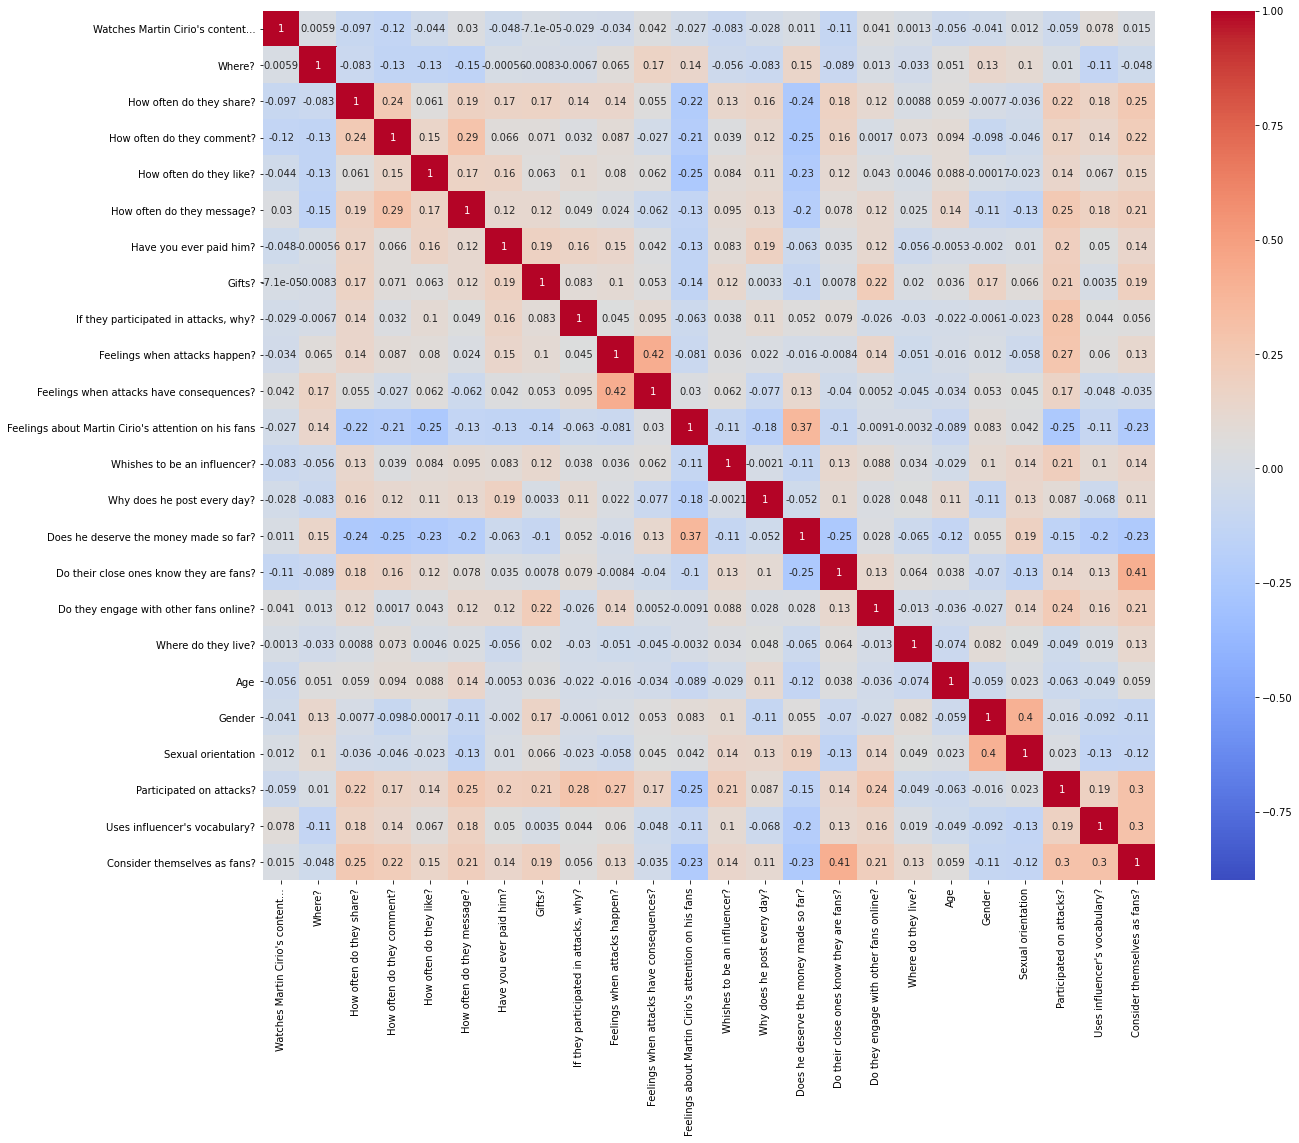

In [42]:
#Durante esta etapa del análisis buscaremos correlaciones entre variables, mientras más cercana a 1 sea la correlación más intensa positivamente será, lo propio
#ocurre con el valor -1 y las correlaciones negativas.

plt.figure(figsize=(20,16))
sns.heatmap(data_num.corr(),vmin=-0.9, cmap='coolwarm',annot=True);

### A- Correlaciones con haber participado en ataques

Participated on attacks?                 1.000000
Consider themselves as fans?             0.296675
If they participated in attacks, why?    0.280582
Feelings when attacks happen?            0.274226
How often do they message?               0.254550
Name: Participated on attacks?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones positivas con participar en ataques a otras cuentas'}>

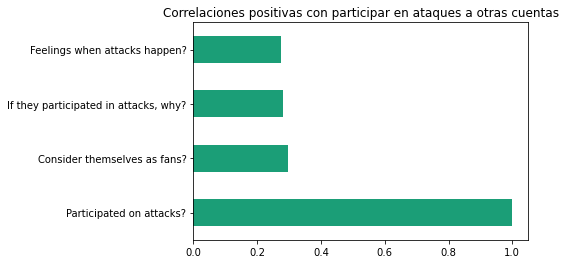

In [43]:
#Ahora queremos ver qué condiciones se correlacionan más intensamente con ese casi 40% de "si". 
#Como todas las variables se correlacionan de una manera u otra, estableceremos el umbral en 6 variables. Las 3 con más correlación positiva y las 3 con más
#correlación negativa, sin contar la propia variable que obviamente se correlaciona en un 100% consigo misma.

print(data_num.corr()["Participated on attacks?"].sort_values(ascending=False).nlargest(5))
pos_corr_a = data_num.corr()["Participated on attacks?"].sort_values(ascending=False).nlargest(4)
pos_corr_a.plot(kind="barh", colormap= "Dark2", title= "Correlaciones positivas con participar en ataques a otras cuentas")

Feelings about Martin Cirio's attention on his fans   -0.248130
Does he deserve the money made so far?                -0.147413
Age                                                   -0.062694
Name: Participated on attacks?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones negativas con participar en ataques a otras cuentas'}>

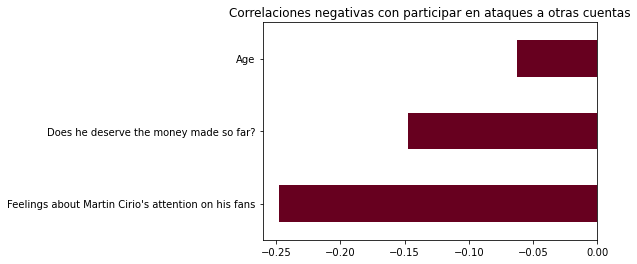

In [44]:
print(data_num.corr()["Participated on attacks?"].sort_values(ascending=False).nsmallest(3))
neg_corr_a = data_num.corr()["Participated on attacks?"].sort_values(ascending=False).nsmallest(3)
neg_corr_a.plot(kind="barh", colormap= "RdGy", title= "Correlaciones negativas con participar en ataques a otras cuentas")

### B- Correlaciones con usar el vocabulario creado por el influencer

Uses influencer's vocabulary?    1.000000
Consider themselves as fans?     0.298713
Participated on attacks?         0.186094
How often do they message?       0.178160
Name: Uses influencer's vocabulary?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones positivas con usar el vocabulario del enunciador'}>

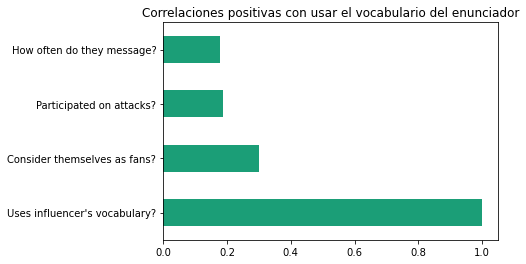

In [45]:
# Confirmamos una de nuestras hipótesis centrales: el uso de vocabulario inventado dentro de la comunidad hace más probable la acción conjunta, por ejemplo los ataques.

print(data_num.corr()["Uses influencer's vocabulary?"].sort_values(ascending=False).nlargest(4))
pos_corr_b = data_num.corr()["Uses influencer's vocabulary?"].sort_values(ascending=False).nlargest(4)
pos_corr_b.plot(kind="barh", colormap= "Dark2", title= "Correlaciones positivas con usar el vocabulario del enunciador")

Does he deserve the money made so far?   -0.202458
Sexual orientation                       -0.125896
Where?                                   -0.113367
Name: Uses influencer's vocabulary?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones negativas con usar el vocabulario del enunciador'}>

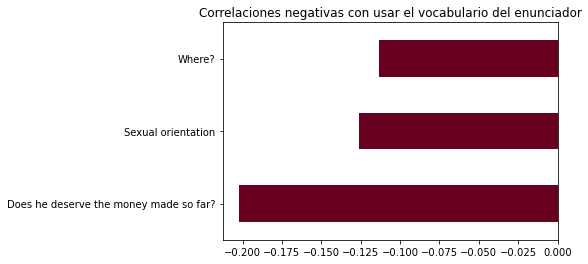

In [46]:
print(data_num.corr()["Uses influencer's vocabulary?"].sort_values(ascending=False).nsmallest(3))
neg_corr_b = data_num.corr()["Uses influencer's vocabulary?"].sort_values(ascending=False).nsmallest(3)
neg_corr_b.plot(kind="barh", colormap= "RdGy", title= "Correlaciones negativas con usar el vocabulario del enunciador")

### C- Correlaciones con reconocerse como fan

Consider themselves as fans?               1.000000
Do their close ones know they are fans?    0.414622
Uses influencer's vocabulary?              0.298713
Participated on attacks?                   0.296675
Name: Consider themselves as fans?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones positivas con reconocerse como fan'}>

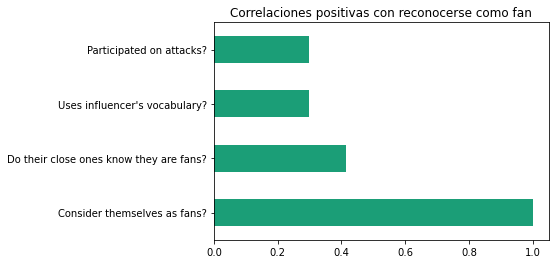

In [47]:
# Quizás las tres variables que más nos interesaban estudiar se correlacionan en estos gráficos: el código compartido, los ataques en conjunto y el status de fan.

print(data_num.corr()["Consider themselves as fans?"].sort_values(ascending=False).nlargest(4))

pos_corr_c = data_num.corr()["Consider themselves as fans?"].sort_values(ascending=False).nlargest(4)
pos_corr_c.plot(kind="barh", colormap= "Dark2", title= "Correlaciones positivas con reconocerse como fan")

Does he deserve the money made so far?                -0.234163
Feelings about Martin Cirio's attention on his fans   -0.230730
Sexual orientation                                    -0.117210
Name: Consider themselves as fans?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones negativas con reconocerse como fan'}>

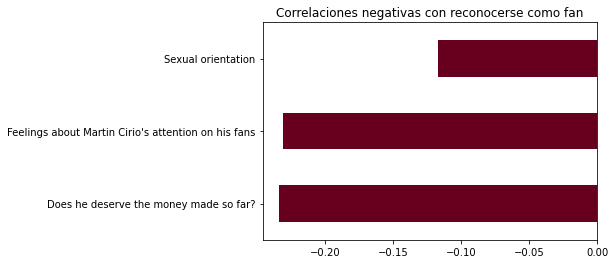

In [48]:
print(data_num.corr()["Consider themselves as fans?"].sort_values(ascending=False).nsmallest(3))
neg_corr_c = data_num.corr()["Consider themselves as fans?"].sort_values(ascending=False).nsmallest(3)
neg_corr_c.plot(kind="barh", colormap= "RdGy", title= "Correlaciones negativas con reconocerse como fan")

### D- Correlaciones con haber dado regalos al influencer

Gifts?                                    1.000000
Do they engage with other fans online?    0.224777
Participated on attacks?                  0.208743
Consider themselves as fans?              0.192837
Name: Gifts?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones positivas'}>

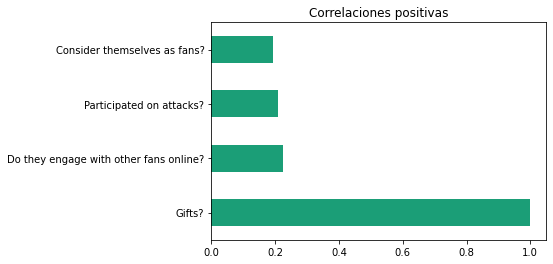

In [49]:
print(data_num.corr()["Gifts?"].sort_values(ascending=False).nlargest(4))
pos_corr_d = data_num.corr()["Gifts?"].sort_values(ascending=False).nlargest(4)
pos_corr_d.plot(kind="barh", colormap= "Dark2", title= "Correlaciones positivas")


Feelings about Martin Cirio's attention on his fans   -0.135408
Does he deserve the money made so far?                -0.101572
Where?                                                -0.008252
Name: Gifts?, dtype: float64


<AxesSubplot:title={'center':'Correlaciones negativas'}>

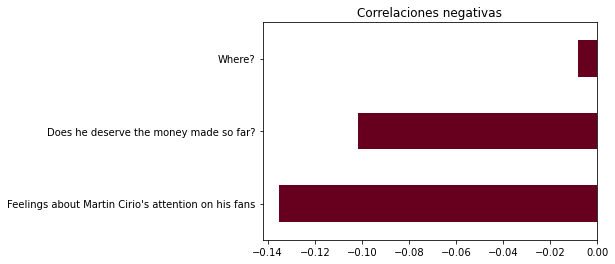

In [50]:
print(data_num.corr()["Gifts?"].sort_values(ascending=False).nsmallest(3))
neg_corr_d = data_num.corr()["Gifts?"].sort_values(ascending=False).nsmallest(3)
neg_corr_d.plot(kind="barh", colormap= "RdGy", title= "Correlaciones negativas")


## 3- Análisis predictivo

In [51]:
#Nuestro objetivo será predecir la participación en ataques de un sujeto, por lo que importamos a nuestro dataset numérico la columna 'Participated on attacks?'.

data['Participated on attacks?'] = pd.get_dummies(data['Participated on attacks?'])
data['Participated on attacks?'].value_counts()

1    235
0    156
Name: Participated on attacks?, dtype: int64

In [52]:
#Y cambiamos el formato, a números enteros.

data_num['Participated on attacks?'] = data['Participated on attacks?'].astype("int")

In [53]:
#La fecha de respuesta del encuestado no formará parte de nuestra predicción, por lo tanto eliminamos esa columna.

data_num.drop("Date", axis=1, inplace=True)

In [54]:
#luego verificamos tener todas las muestras completas con las columnas que precisamos.

data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype
---  ------                                               --------------  -----
 0   Watches Martin Cirio's content...                    391 non-null    int64
 1   Where?                                               391 non-null    int64
 2   How often do they share?                             391 non-null    int64
 3   How often do they comment?                           391 non-null    int64
 4   How often do they like?                              391 non-null    int64
 5   How often do they message?                           391 non-null    int64
 6   Have you ever paid him?                              391 non-null    int64
 7   Gifts?                                               391 non-null    int64
 8   If they participated in attacks, why?                391 non-null    int64
 9   Feelings w

In [55]:
#Este es un escalador de datos numéricos, para que ninguna columna tenga valores numéricamente más altos que las demás y por ende el algoritmo de predicción no las interprete como más "valiosas" o "pesadas".

numerical = ["Watches Martin Cirio's content...", 'Where?','How often do they share?', 'How often do they comment?','How often do they like?', 'How often do they message?',
       'Have you ever paid him?', 'Gifts?','If they participated in attacks, why?','Feelings when attacks happen?','Feelings when attacks have consequences?',
       "Feelings about Martin Cirio's attention on his fans",'Whishes to be an influencer?', 'Why does he post every day?','Does he deserve the money made so far?',
       'Do their close ones know they are fans?','Do they engage with other fans online?', 'Where do they live?', 'Age','Gender', 'Sexual orientation',
       "Uses influencer's vocabulary?", 'Consider themselves as fans?']


numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
normal = ColumnTransformer(transformers=[('num', numeric_transformer, numerical)])

engineer = Pipeline([('normal',normal)])


In [56]:
#El método RepeatedKFold define un esquema de validación cruzada con 10 submuestras que corren 3 repeticiones alternas. La validación cruzada evita que los resultados del modelo predictivo se vean sesgados por algún tipo de ruido o relación espuria.
#Luego dividimos los datos en un set de entrenamiento y un set de testeo. De esa manera, el 75% de los datos servirán para entrenar a nuestro modelo y el 25% restante emulará a los datos "en su estado natural", siendo el objetivo del testeo final
#de nuestro modelo.

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

X = data_num.drop('Participated on attacks?', axis=1)
y = data_num['Participated on attacks?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [57]:
#Esta función servirá para visualizar nuestra predicción en los próximos bloques.
 
def accuracy(y_test, y_pred):
    print('Recall Score:',recall_score(y_test,y_pred).round(2))
    print('Precision Score:',precision_score(y_test,y_pred).round(2))
    print("F1 Score:", f1_score(y_test,y_pred, average="weighted").round(2))
    
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.0f')
    plt.ylabel('Verdaderos', fontdict={"fontsize":14})
    plt.xlabel('Predichos',fontdict={"fontsize":14})
    

In [58]:
#Y finalmente, aquí llegamos a la implementanción del modelo predictivo. 
#El modelo predijo con una precisión del 91%
#Teniendo en cuenta lo pequeña que es nuestra muestra, creemos que futuros trabajos con más recursos y más encuestados podrían llegar a predecir ataques de trolls con cerca del 99% de precisión. 

pipeline_lgbm = Pipeline(steps=[('feature_engineering',engineer),
                                ('lgbm',LGBMClassifier())])

params_lgbm = {"lgbm__num_leaves": (7, 4095, 1), "lgbm__max_depth": (2, 63, 1), "lgbm__scale_pos_weight": (1, 10000, 2),
               "lgbm__min_child_weight": (0.01, 1.6, 0.01), "lgbm__subsample": (0.4, 1, 0.1), "lgbm__colsample_bytree": (0.4, 1, 0.1)}

grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid = params_lgbm, cv=cv, n_jobs=-1)
grid_lgbm.fit(X_train,y_train)
predictions = grid_lgbm.predict(X_test)
print("Score:", round(grid_lgbm.best_score_,2))
print(grid_lgbm.best_params_)


Score: 0.91
{'lgbm__colsample_bytree': 1, 'lgbm__max_depth': 1, 'lgbm__min_child_weight': 0.01, 'lgbm__num_leaves': 7, 'lgbm__scale_pos_weight': 2, 'lgbm__subsample': 0.4}


Recall Score: 0.91
Precision Score: 0.91
F1 Score: 0.9


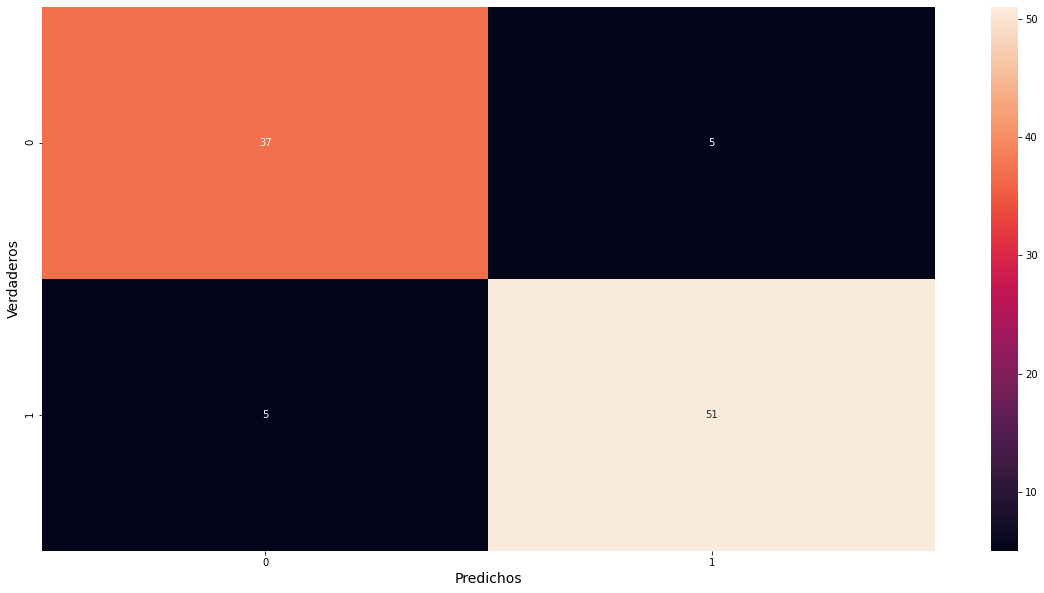

In [59]:
#De esta matriz de confusión se deriva que sobre un set de 88 muestras, solo hubo 5 falsos positivos y 5 falsos negativos. Luego el modelo identificó correctamente las demás respuestas.
#*Debe tenerse en cuenta que por el tamaño del set de testeo y la naturaleza aproximada del algoritmo, los resultados pueden variar de ejecución en ejecución

accuracy(y_test, predictions)